In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import umap
import random
import warnings
warnings.filterwarnings('ignore')

c:\Users\dweis\OneDrive\Documents\Career\Research Paper\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_folder = r"C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Data\Data_Per_Wind_Farm"
n_clusters = 6
years_to_use = 2
start_date = '2018-01-01'
end_date = '2020-01-01'
random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
def load_all_wind_farms(data_folder):

    print(f"\n{'='*80}")
    print("LOADING WIND FARM DATA")
    print(f"{'='*80}\n")
    
    all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    print(f"Found {len(all_files)} CSV files\n")
    
    all_dfs = []
    
    for filename in all_files:
        filepath = os.path.join(data_folder, filename)
        farm_name = filename.replace('.csv', '')
        
        try:
            df = pd.read_csv(filepath)
            
            if 'Unnamed: 0' in df.columns:
                df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
            if 'time' in df.columns:
                df.rename(columns={'time': 'Time'}, inplace=True)
            
            df['farm_id'] = farm_name
            df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
            df = df.dropna(subset=['Time'])
            
            print(f"  {farm_name:<40} | {len(df):>8} rows")
            all_dfs.append(df)
            
        except Exception as e:
            print(f"  {farm_name:<40} | ERROR: {e}")
            continue
    
    df_all = pd.concat(all_dfs, axis=0, ignore_index=True)
    
    print(f"\n{'='*80}")
    print(f"Total farms loaded: {df_all['farm_id'].nunique()}")
    print(f"Total rows: {len(df_all):,}")
    print(f"{'='*80}\n")
    
    return df_all

In [7]:
def extract_farm_features(df_all, start_date, end_date):

    print(f"\n{'='*80}")
    print("FEATURES FOR EACH WIND FARM")
    print(f"{'='*80}\n")
    print(f"Using data from {start_date} to {end_date}\n")
    
    farm_features = []
    farm_metadata = []
    
    for farm_id in df_all['farm_id'].unique():
        farm_data = df_all[df_all['farm_id'] == farm_id].copy()
        
        farm_data = farm_data[
            (farm_data['Time'] >= start_date) & 
            (farm_data['Time'] < end_date)
        ]
        
        # Remove Turn_off = 0 
        if 'Turn_off' in farm_data.columns:
            initial_len = len(farm_data)
            farm_data = farm_data[farm_data['Turn_off'] != 0].copy()
            removed = initial_len - len(farm_data)
            if removed > 0:
                print(f"  {farm_id}: Removed {removed} hours where Turn_off=0")
        
        required_cols = ['Windspeed', 'Wind_Direction', 'fsr', 'u100', 'v100']
        missing_cols = [col for col in required_cols if col not in farm_data.columns]
        if missing_cols:
            print(f"  Skipping {farm_id}: missing columns {missing_cols}")
            continue
        
        farm_data['Power'] = pd.to_numeric(farm_data['Power'], errors='coerce')
        farm_data = farm_data.dropna(subset=['Power'])
        
        features = []
        

        # 1: Wind Speed Stats (7 features)

        ws_mean = farm_data['Windspeed'].mean()
        ws_std = farm_data['Windspeed'].std()
        ws_10 = farm_data['Windspeed'].quantile(0.10)
        ws_90 = farm_data['Windspeed'].quantile(0.90)
        ws_high_pct = (farm_data['Windspeed'] > 12).sum() / len(farm_data)
        ws_low_pct = (farm_data['Windspeed'] < 4).sum() / len(farm_data)
        
        features.extend([ws_mean, ws_std, ws_10, ws_90, ws_high_pct, ws_low_pct])
        

        # 2: Sea Surface Roughness Stats (5 features)

        fsr_mean = farm_data['fsr'].mean()
        fsr_std = farm_data['fsr'].std()
        fsr_90 = farm_data['fsr'].quantile(0.90)
        fsr_10 = farm_data['fsr'].quantile(0.10)
        
        features.extend([fsr_mean, fsr_std, fsr_90, fsr_10])
        

        # 3: Wind Direction Stats (4 features)

        wd_rad = np.deg2rad(farm_data['Wind_Direction'])
        mean_sin = np.mean(np.sin(wd_rad))
        mean_cos = np.mean(np.cos(wd_rad))
        directional_consistency = np.sqrt(mean_sin**2 + mean_cos**2)
        wd_std = farm_data['Wind_Direction'].std()
        
        features.extend([mean_sin, mean_cos, directional_consistency, wd_std])
        

        # 4: Atmospheric Components (6 features)

        u100_mean = farm_data['u100'].mean()
        u100_std = farm_data['u100'].std()
        v100_mean = farm_data['v100'].mean()
        v100_std = farm_data['v100'].std()
        
        u_ratio = u100_mean / (ws_mean + 1e-6)
        v_ratio = v100_mean / (ws_mean + 1e-6)
        
        features.extend([u100_mean, u100_std, v100_mean, v100_std, u_ratio, v_ratio])
        

        # 5: Power Output Stats (6 features)

        power_mean = farm_data['Power'].mean()
        power_std = farm_data['Power'].std()
        power_max = farm_data['Power'].max()
        capacity_factor = power_mean / (power_max + 1e-6)
        
        # Wind-Power relationship
        ws_power_corr = np.corrcoef(farm_data['Windspeed'], farm_data['Power'])[0, 1]
        power_efficiency = power_mean / (ws_mean + 1e-6)
        
        features.extend([power_mean, power_std, power_max, capacity_factor, ws_power_corr, power_efficiency])
        

        # 6: Seasonal Patterns (4 features)

        farm_data['Month'] = farm_data['Time'].dt.month
        monthly_ws = farm_data.groupby('Month')['Windspeed'].mean()
        monthly_fsr = farm_data.groupby('Month')['fsr'].mean()
        
        seasonal_ws_std = monthly_ws.std()
        seasonal_ws_range = monthly_ws.max() - monthly_ws.min()
        seasonal_fsr_std = monthly_fsr.std()
        peak_wind_month = monthly_ws.idxmax()
        
        features.extend([seasonal_ws_std, seasonal_ws_range, seasonal_fsr_std, peak_wind_month])
        

        # 7: Diurnal Patterns (3 features)

        farm_data['Hour'] = farm_data['Time'].dt.hour
        hourly_ws = farm_data.groupby('Hour')['Windspeed'].mean()
        
        diurnal_ws_std = hourly_ws.std()
        diurnal_ws_range = hourly_ws.max() - hourly_ws.min()
        peak_wind_hour = hourly_ws.idxmax()
        
        features.extend([diurnal_ws_std, diurnal_ws_range, peak_wind_hour])
        

        # 8: Wind Speed Variability (3 features)

        ws_diff = np.abs(np.diff(farm_data['Windspeed'].values))
        ws_change_mean = np.mean(ws_diff)
        ws_change_std = np.std(ws_diff)
        ws_rapid_transitions = (ws_diff > 3).sum() / len(ws_diff)
        
        features.extend([ws_change_mean, ws_change_std, ws_rapid_transitions])
        

        # 9: Extreme Events (2 features)

        ws_99 = farm_data['Windspeed'].quantile(0.99)
        extreme_events_pct = (farm_data['Windspeed'] > ws_99).sum() / len(farm_data)
        
        features.extend([ws_99, extreme_events_pct])
        
        farm_features.append(features)
        farm_metadata.append({
            'farm_id': farm_id,
            'n_samples': len(farm_data),
            'mean_power': power_mean,
            'max_power': power_max,
            'capacity_factor': capacity_factor,
            'mean_windspeed': ws_mean
        })
        
        print(f" {farm_id:<40} | {len(farm_data):>8} hours | "
              f"WS: {ws_mean:.2f} m/s | Power: {power_mean:.0f} MW | Cap: {power_max:.0f} MW")
    
    farm_features = np.array(farm_features)
    
    print(f"\n{'='*80}")
    print(f"Successfully extracted features for {len(farm_metadata)} farms")
    print(f"Feature vector size: {farm_features.shape[1]} features per farm")
    print(f"{'='*80}\n")
    
    return farm_features, farm_metadata

In [8]:
def apply_umap_reduction(farm_features, n_farms):

    print(f"\n{'='*80}")
    print("APPLYING UMAP DIMENSIONALITY REDUCTION")
    print(f"{'='*80}\n")
    
    scaler = StandardScaler()
    farm_features_normalized = scaler.fit_transform(farm_features)
    
    n_components = max(2, min(3, n_farms - 1))
    
    print(f"Number of farms: {n_farms}")
    print(f"Original feature space: {farm_features.shape[1]} dimensions")
    print(f"Target feature space: {n_components} dimensions")
    print(f"Running UMAP...\n")
    
    # Apply UMAP
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=min(15, n_farms - 1), 
        min_dist=0.1,
        metric='euclidean',
        random_state=random_seed,
        verbose=False
    )
    
    farm_features_umap = reducer.fit_transform(farm_features_normalized)
    
    print(f"✓ UMAP completed")
    print(f"  Reduced to shape: {farm_features_umap.shape}")
    print(f"{'='*80}\n")
    
    return farm_features_umap, farm_features_normalized, scaler, reducer

In [9]:
def cluster_farms_in_umap_space(farm_features_umap, farm_metadata, n_clusters):

    n_farms = len(farm_metadata)
    
    print(f"\n{'='*80}")
    print(f"CLUSTERING {n_farms} FARMS INTO {n_clusters} GROUPS")
    print(f"{'='*80}\n")
    
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='ward',
        metric='euclidean'
    )
    
    cluster_labels = clustering.fit_predict(farm_features_umap)
    
    # Evaluate clustering quality 
    silhouette = silhouette_score(farm_features_umap, cluster_labels)
    davies_bouldin = davies_bouldin_score(farm_features_umap, cluster_labels)
    
    print(f"Clustering Quality Metrics:")
    print(f"  Silhouette Score: {silhouette:.3f} (higher is better)")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
    
    print(f"\n{'='*80}\n")
    
    # Assign clusters to metadata
    for i, meta in enumerate(farm_metadata):
        meta['cluster'] = cluster_labels[i]
    
    results_df = pd.DataFrame(farm_metadata)
    
    print("CLUSTER COMPOSITION:")
    print(f"{'='*80}\n")
    
    for cluster_id in range(n_clusters):
        cluster_farms = results_df[results_df['cluster'] == cluster_id]
        print(f"Cluster {cluster_id} ({len(cluster_farms)} farms):")
        for _, farm in cluster_farms.iterrows():
            print(f"  • {farm['farm_id']:<40} | "
                  f"WS: {farm['mean_windspeed']:>5.2f} m/s | "
                  f"Power: {farm['mean_power']:>6.0f} MW | "
                  f"CF: {farm['capacity_factor']:>5.1%}")
        print()
    
    return cluster_labels, results_df, silhouette, davies_bouldin, n_clusters

In [14]:
def visualise_clustering(farm_features_umap, farm_metadata, cluster_labels, n_clusters):
    
    x = farm_features_umap[:, 0]
    y = farm_features_umap[:, 1]
    
    fig, ax = plt.subplots(figsize=(20, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    

    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        ax.scatter(
            x[mask], y[mask],
            c=[colors[cluster_id]],
            s=150,
            alpha=0.6,
            label=f'Cluster {cluster_id}',
            edgecolors='black',
            linewidth=1
        )
    
    for i, meta in enumerate(farm_metadata):
        ax.annotate(
            meta['farm_id'][:20],
            (x[i], y[i]),
            fontsize=8,
            alpha=0.7,
            ha='center'
        )
    
    ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
    ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
    ax.set_title('All Wind Farms - Clustered in UMAP Space',
                 fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    save_path = r'C:\Users\dweis\OneDrive\Documents\Career\Research Paper\Figures\Selecting Source Farms\wind_farm_clustering_umap.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f" Figure saved to: {save_path}")
    
    plt.show()

In [17]:
def full_pipeline():
    
    #Load all wind farms
    df_all = load_all_wind_farms(data_folder)
    
    # Extract features for each farm
    farm_features, farm_metadata = extract_farm_features(df_all, start_date, end_date)
    
    # Apply UMAP
    farm_features_umap, farm_features_normalized, scaler, reducer = apply_umap_reduction(
        farm_features, 
        n_farms=len(farm_metadata)
    )
    
    # Cluster in UMAP space
    cluster_labels, results_df, silhouette, davies_bouldin, actual_n_clusters = cluster_farms_in_umap_space(
        farm_features_umap, 
        farm_metadata, 
        n_clusters=n_clusters
    )
    
    # Visualize
    visualise_clustering(
        farm_features_umap, 
        farm_metadata, 
        cluster_labels,
        n_clusters=actual_n_clusters
    )
    
    return {
        'results_df': results_df,
        'farm_features_umap': farm_features_umap,
        'cluster_labels': cluster_labels,
        'silhouette_score': silhouette,
        'davies_bouldin_score': davies_bouldin
    }


LOADING WIND FARM DATA

Found 29 CSV files

  Baie_de_Saint_Brieuc                     |   350640 rows
  Baltic_Eagle                             |   350640 rows
  Beatrice                                 |   350640 rows
  Borkum_Riffgrund                         |   350640 rows
  Borssele_(Phase_1,2)                     |   350640 rows
  Borssele_(Phase_3,4)                     |   350640 rows
  Dieppe_et_Le_Treport                     |   350640 rows
  Dogger_Bank_(Phase_A,B)                  |   350640 rows
  East_Anglia_One                          |   350640 rows
  Gemini                                   |   350640 rows
  Gode_Wind                                |   350640 rows
  Greater_Gabbard                          |   350640 rows
  Gwynt_y_Mor                              |   350640 rows
  Hautes_Falaises                          |   350640 rows
  Hohe_See                                 |   350640 rows
  Hollandse_Kust_Noord                     |   350640 rows
  Hollandse

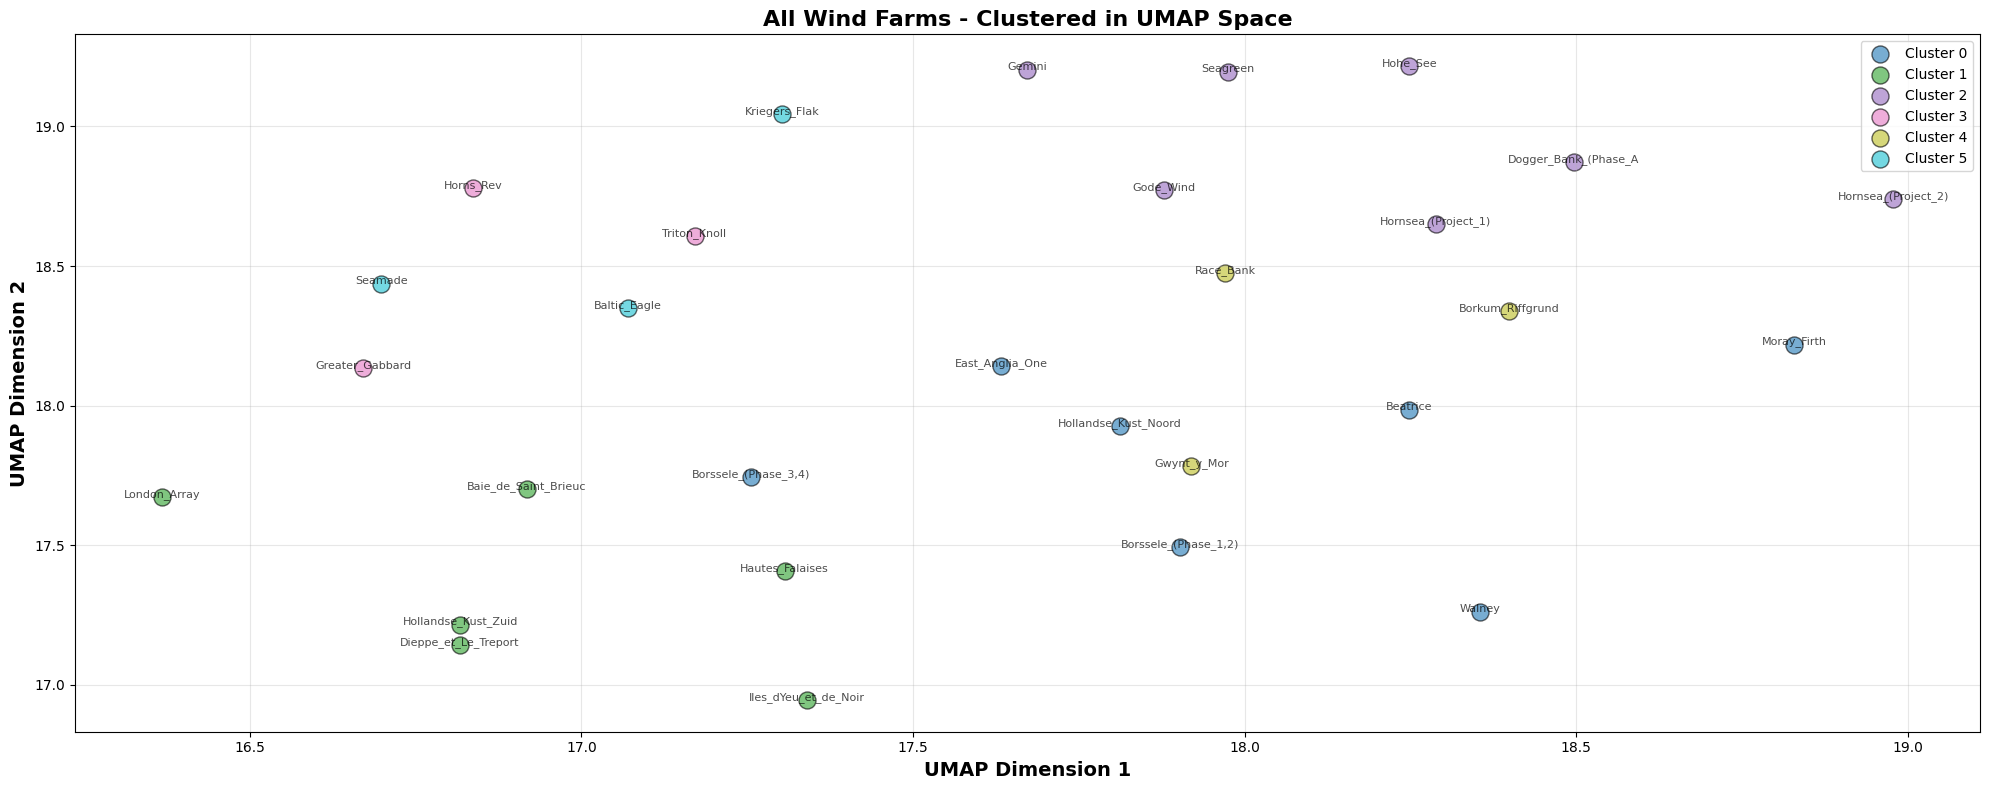

In [18]:
results = full_pipeline()